In [1]:
%%capture
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import interpolate
import math
import sys
from scipy import signal
import pandas as pd
import tensorflow as tf
from numba import cuda
import numba
import os
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
%run GRUSupportFns.ipynb
import mpld3
mpld3.enable_notebook()


In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, Bidirectional, LSTM
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import backend as K 
from IPython.display import clear_output
from tensorflow.python.keras.initializers import RandomUniform
# tf.enable_eager_execution()

## Load DataStream and Ground Truth
As no reliable ground truth currently, using Kalman Filter results. Note: Ground truth must currently have the same timesteps as the input.

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

In [3]:
training_data, training_labels, test_data, test_labels,_ = load_train_test_data('uni.csv', 0.8)

Parsed File
Freq. of Acceleration 1583.554443181799
Freq. of Lin. Acceleration 669.8833983859098
Freq. of Gyroscope 1585.3892195648934
Interpolated Samples
Loaded Ground Truth
Rotated Acceleration
Integrated Acceleration


In [4]:
norm_training_data, norm_training_labels, norm_test_data, norm_test_labels = scale_data(training_data, training_labels, 
                                                                                        test_data, test_labels)

    

In [ ]:
plt.figure(figsize=(9, 8))
ax=plt.subplot(111)
for i in range(0, len(norm_training_data), 100):
    plt.plot(norm_training_data[i*100:(i+1)*100], norm_training_labels[i*100:(i+1)*100])

In [5]:
validation_data = (np.expand_dims(norm_test_data, axis=0), 
                   np.expand_dims(norm_test_labels, axis=0))

## Start Tensorflow Session 

Batches in the shape (Batch Size, Sequence Length, Feature Vector Length)

Hyper-parameters:
 - Batch Size
 - Sequence Length
 - Number of States in RNN layer
 - GRU or LSTM Layer
 - All forward facing layers, or bidirectional


In [6]:
sess = tf.InteractiveSession()
generator = batch_generator(batch_size=512, sequence_length=100)

In [7]:
model = Sequential()
model.add(GRU(units=128, return_sequences=True, input_shape=(None, x_dim,)))
model.add(GRU(units=128, return_sequences=True, input_shape=(None, x_dim,)))
model.add(GRU(units=128, return_sequences=True, input_shape=(None, x_dim,)))
model.add(GRU(units=128, return_sequences=True, input_shape=(None, x_dim,)))
model.add(GRU(units=128, return_sequences=True, input_shape=(None, x_dim,)))
model.add(GRU(units=128, return_sequences=True, input_shape=(None, x_dim,)))
# model.add(GRU(units=1024, return_sequences=True))
model.add(Dense(y_dim, activation='linear'))

In [8]:
# model = Sequential()
# model.add(Bidirectional(GRU(units=256, return_sequences=True), merge_mode='ave',input_shape=(None, x_dim,)))
# model.add(Bidirectional(GRU(units=256, return_sequences=True), merge_mode='ave',input_shape=(None, x_dim,)))
# model.add(Bidirectional(GRU(units=256, return_sequences=True), merge_mode='ave',input_shape=(None, x_dim,)))
# model.add(Dense(y_dim, activation='linear'))         

In [9]:
warmup_steps = 20

### Compile the Model

In [10]:
optimizer = Adam(lr=1e-3)
model.compile(loss=custom_loss, optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 128)         53760     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
gru_4 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
gru_5 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
dense (Dense)                (None, None, 2)           258       
Total para

In [11]:
# path_checkpoint = '23_checkpoint.keras'
# callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
#                                       monitor='val_loss',
#                                       verbose=1,
#                                       save_weights_only=True,
#                                       save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)
# callback_tensorboard = TensorBoard(log_dir='./23_logs/',
#                                    histogram_freq=0,
#                                    write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-9,
                                       patience=0,
                                       verbose=1)       
plot_losses = PlotLosses()

callbacks = [callback_early_stopping,
#              callback_checkpoint,
#              callback_tensorboard,
             plot_losses,
             callback_reduce_lr]


## Train the Model
 - Choose the maximum amount of epochs
 - How many batches of the data per epoch

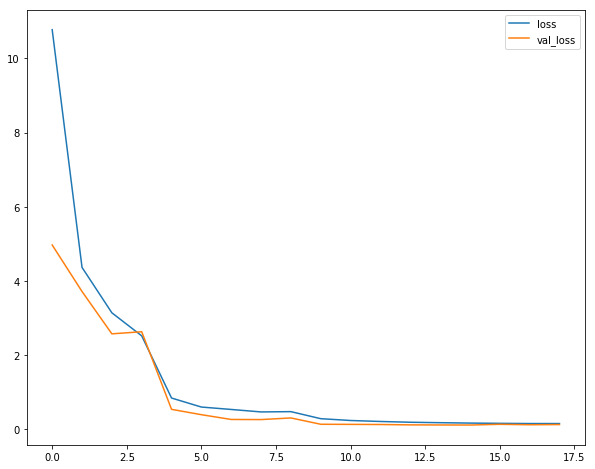


Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
160/160 [==============================] - 128s 799ms/step - loss: 0.1577 - val_loss: 0.1304
Epoch 00018: early stopping
CPU times: user 49min 41s, sys: 3min 35s, total: 53min 16s
Wall time: 39min 2s


In [12]:
%%time
# model.fit(np.expand_dims(scaled_training_data, axis=0), np.expand_dims(scaled_training_labels, axis=0), epochs=10, 
#           batch_size=32, validation_data=validation_data, callbacks=callbacks)
model.fit_generator(generator=generator,
                    epochs=60,
                    steps_per_epoch=160, #Number of batches per epoch
                    validation_data=validation_data,
                    callbacks=callbacks)

## Evaluate Model on Test Data

In [13]:
result = model.evaluate(x=np.expand_dims(norm_test_data, axis=0),
                        y=np.expand_dims(norm_test_labels, axis=0))
print("loss (test-set):", result)

1/1 [==============================] - 29s 29s/step
loss (test-set): 0.13039159774780273


Parsed File
Freq. of Acceleration 190.0300697928473
Freq. of Lin. Acceleration 49.00211454776328
Freq. of Gyroscope 52.67300802601869
Interpolated Samples
Loaded Ground Truth
Rotated Acceleration
Integrated Acceleration


<IPython.core.display.Javascript object>


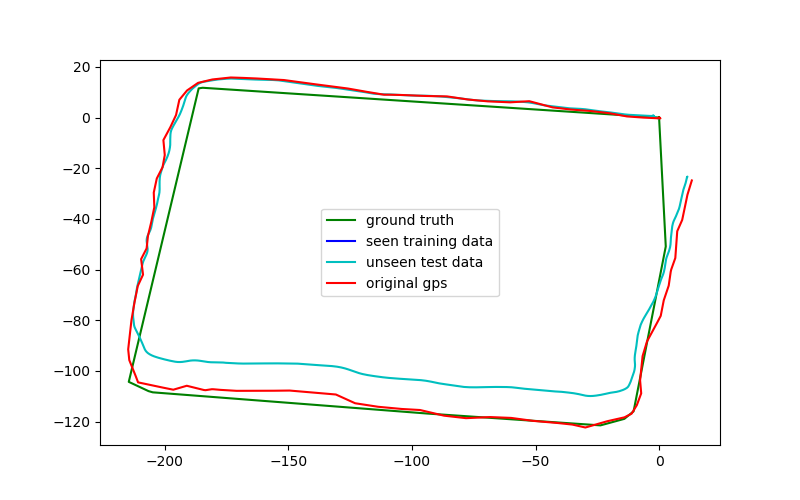

Accuracy of GPS:  26.241340643469794
Accuracy of RNN:  29.658431499255165


In [14]:
%matplotlib notebook
plot_comparison('data5.csv', train_percentage=0.0)

Parsed File
Freq. of Acceleration 1583.554443181799
Freq. of Lin. Acceleration 669.8833983859098
Freq. of Gyroscope 1585.3892195648934
Interpolated Samples
Loaded Ground Truth
Rotated Acceleration
Integrated Acceleration


<IPython.core.display.Javascript object>


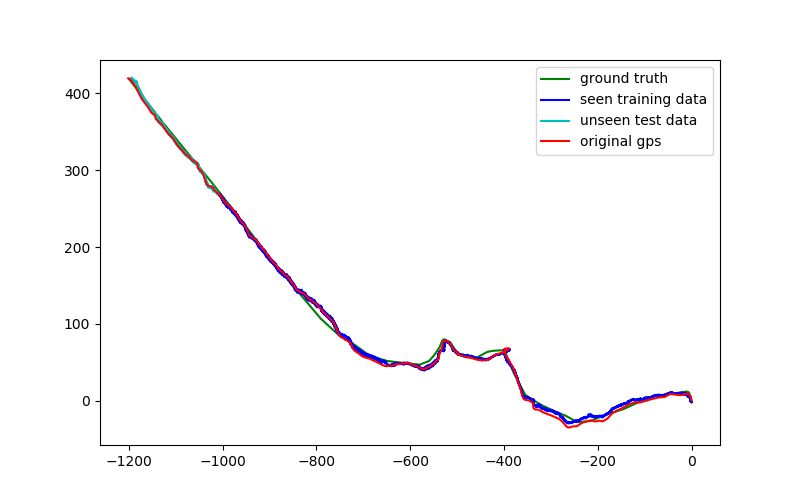

Accuracy of GPS:  3.94581792431503
Accuracy of RNN:  4.092047134670278


In [15]:
plot_comparison('uni.csv', train_percentage=0.80, start_index = 100)

## Reset Tensorflow Graph

In [16]:
# tf.reset_default_graph()
# sess.close()